In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import time


C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.__version__, torchdata.__version__, torchtext.__version__

('2.2.2+cpu', '0.7.1', '0.17.2+cpu')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
SEED = 1234 #change three times
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 1. load dataset

In [5]:
df = pd.read_json('../data/train-qar.jsonl', lines=True, nrows=300000)
df = df[['category', 'questionText']]
df.head(5)

,category,questionText
0,Toys_and_Games,"Many have stated similar to the following: ""Pa..."
1,Health_and_Personal_Care,Will these work with the Phillips sonicare han...
2,Cell_Phones_and_Accessories,What kind of sim card it use?
3,Home_and_Kitchen,does anyone know if this dinnerware set does n...
4,Musical_Instruments,I'm thinking of getting in to modular synthesi...


In [6]:
# Product category
df['category'].unique()

array(['Toys_and_Games', 'Health_and_Personal_Care',
       'Cell_Phones_and_Accessories', 'Home_and_Kitchen',
       'Musical_Instruments', 'Baby', 'Sports_and_Outdoors',
       'Patio_Lawn_and_Garden', 'Video_Games', 'Pet_Supplies',
       'Tools_and_Home_Improvement', 'Beauty', 'Electronics',
       'Grocery_and_Gourmet_Food', 'Automotive', 'Office_Products',
       'Clothing_Shoes_and_Jewelry'], dtype=object)

In [7]:
df['category'].value_counts()[:10]

Electronics                    69163
Home_and_Kitchen               43733
Sports_and_Outdoors            28873
Tools_and_Home_Improvement     25503
Health_and_Personal_Care       19230
Automotive                     18688
Cell_Phones_and_Accessories    17052
Patio_Lawn_and_Garden          14845
Toys_and_Games                 12599
Office_Products                10436
Name: category, dtype: int64

In [8]:
# convert the text to numeric class
# class_mapping = {
#     'Toys_and_Games': 0,
#     'Health_and_Personal_Care': 1,
#     'Cell_Phones_and_Accessories': 2,
#     'Home_and_Kitchen': 3,
#     'Musical_Instruments': 4,
#     'Baby': 5,
#     'Sports_and_Outdoors': 6,
#     'Patio_Lawn_and_Garden': 7,
#     'Video_Games': 8,
#     'Pet_Supplies': 9,
#     'Tools_and_Home_Improvement': 10,
#     'Beauty': 11,
#     'Electronics': 12,
#     'Grocery_and_Gourmet_Food': 13,
#     'Automotive': 14,
#     'Office_Products': 15,
#     'Clothing_Shoes_and_Jewelry': 16
# }

class_mapping = {
    'Electronics': 0,
    'Home_and_Kitchen': 1,
    'Sports_and_Outdoors': 2,
    'Tools_and_Home_Improvement': 3,
    'Health_and_Personal_Care': 4,
    'Automotive': 5,
    'Cell_Phones_and_Accessories': 6,
    # 'Patio_Lawn_and_Garden': 7,
    # 'Toys_and_Games': 8,
    # 'Office_Products': 9
}

# Map class names to numerical labels
df['category'] = df['category'].map(class_mapping)

In [9]:
# sample 100 data in each classes
df_sample = df.groupby('category', group_keys=False).apply(lambda x: x.sample(10000))

In [10]:
# convert to lower case
df_sample['questionText']  =  df_sample['questionText'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [11]:
def data_cleaning(data):
    regex_s = re.sub("\\(.+?\\)|[\r\n|\n\r]|!", "", data)
    fin = " ".join(regex_s.split())
    return fin

In [12]:
df_sample['questionText'] = df_sample['questionText'].apply(data_cleaning)

In [13]:
df_sample = df_sample.astype({'category':int})

In [14]:
train_df, val_df = train_test_split(df_sample, test_size=0.1,stratify=df_sample['category'], random_state=SEED)

In [15]:
train_df, test_df = train_test_split(train_df, test_size=0.1, stratify=train_df['category'],random_state=SEED)

In [16]:
train_df['category'].value_counts()

3    8100
1    8100
6    8100
2    8100
0    8100
4    8100
5    8100
Name: category, dtype: int64

In [17]:
train_df

,category,questionText
128446,3,will cleaning the toilet deteriorate or harm t...
20955,3,what sort of electrical connection is it?
168416,1,what height chair fits under this desk?
236269,6,does the screen help with fingerprints at all?
112000,2,does this keep the water off your skin at all?...
...,...,...
149929,3,i need to write names on drinking glasses. wou...
10328,1,is it available in a jar 4 3/4 inches high ?
249890,6,can anyone tell me if this phone is supposed t...
52377,5,is it a pair or just one shock


## 2.Preprocessing

### Tokenizing

In [18]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens    = tokenizer("What is the best product?")
tokens

['What', 'is', 'the', 'best', 'product', '?']

### Text to integers (numeral)

In [19]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data):
    for data_sample in data:
        yield tokenizer(data_sample) 
        
vocab = build_vocab_from_iterator(yield_tokens(train_df['questionText']), specials = ['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [20]:
vocab(['here', 'it', 'is'])

[457, 9, 7]

In [21]:
mapping = vocab.get_itos()
mapping[0]

'<unk>'

In [22]:
len(vocab)

30929

In [23]:
import dill

# Save it to a file
with open('model/7class/vocab.pkl', 'wb') as f:
    dill.dump(vocab, f)

## 3. Data loader

### FastText Embedding

In [24]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [25]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

In [26]:
fast_embedding.shape

torch.Size([30929, 300])

In [27]:
class DataWrap(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [28]:
train_df.iloc[0]

category                                                        3
questionText    will cleaning the toilet deteriorate or harm t...
Name: 128446, dtype: object

In [29]:
train = DataWrap(train_df)
valid = DataWrap(val_df)
test = DataWrap(test_df)

In [30]:
# Define your lambda function
text_pipeline = lambda x: vocab(tokenizer(x))

In [31]:
text_pipeline("What is the best product?")

[0, 7, 5, 322, 56, 4]

In [32]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] 

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True)

In [33]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch) #num_workers to train faster
val_loader   = DataLoader(valid, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [34]:
for label, text in val_loader:
    break

In [35]:
label.shape #(batch_size, )

torch.Size([64])

In [36]:
text.shape #(batch_size, seq len)

torch.Size([64, 32])

## 4. Model (CNN)

In [37]:
class CNN(nn.Module): #more elegant version
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
                
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, emb_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

## 5. Train

In [38]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [39]:
input_dim  = len(vocab)
emb_dim    = 300
output_dim = 7 #7 classes

#for cnn
dropout = 0.5
n_filters = 50
filter_sizes = [3, 4, 5]

model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [40]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(sum(params))    

In [41]:
count_parameters(model)

9459907


In [42]:
import torch.optim as optim

lr=0.02

#training hyperparameters
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

C:\Users\earth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [43]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [44]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [45]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Actual training

In [46]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [48]:
import torch.nn.functional as F
import time
best_valid_loss = float('inf')
num_epochs      = 30

save_path = 'model/7class/CNN.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_scripted = torch.jit.script(model)
        model_scripted.save(save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 50s
	Train Loss: 1.750 | Train Acc: 30.83%
	 Val. Loss: 1.530 |  Val. Acc: 45.55%
Epoch: 02 | Time: 0m 49s
	Train Loss: 1.515 | Train Acc: 43.14%
	 Val. Loss: 1.426 |  Val. Acc: 48.81%
Epoch: 03 | Time: 0m 50s
	Train Loss: 1.431 | Train Acc: 47.18%
	 Val. Loss: 1.370 |  Val. Acc: 51.39%
Epoch: 04 | Time: 0m 49s
	Train Loss: 1.375 | Train Acc: 49.94%
	 Val. Loss: 1.331 |  Val. Acc: 52.18%
Epoch: 05 | Time: 0m 49s
	Train Loss: 1.335 | Train Acc: 51.67%
	 Val. Loss: 1.301 |  Val. Acc: 53.42%
Epoch: 06 | Time: 0m 49s
	Train Loss: 1.301 | Train Acc: 52.76%
	 Val. Loss: 1.280 |  Val. Acc: 54.15%
Epoch: 07 | Time: 0m 49s
	Train Loss: 1.274 | Train Acc: 54.02%
	 Val. Loss: 1.264 |  Val. Acc: 55.25%
Epoch: 08 | Time: 0m 49s
	Train Loss: 1.250 | Train Acc: 54.88%
	 Val. Loss: 1.248 |  Val. Acc: 55.45%
Epoch: 09 | Time: 0m 49s
	Train Loss: 1.229 | Train Acc: 55.96%
	 Val. Loss: 1.237 |  Val. Acc: 55.94%
Epoch: 10 | Time: 0m 49s
	Train Loss: 1.207 | Train Acc: 56.68%
	 Val. Lo

Text(0, 0.5, 'loss')

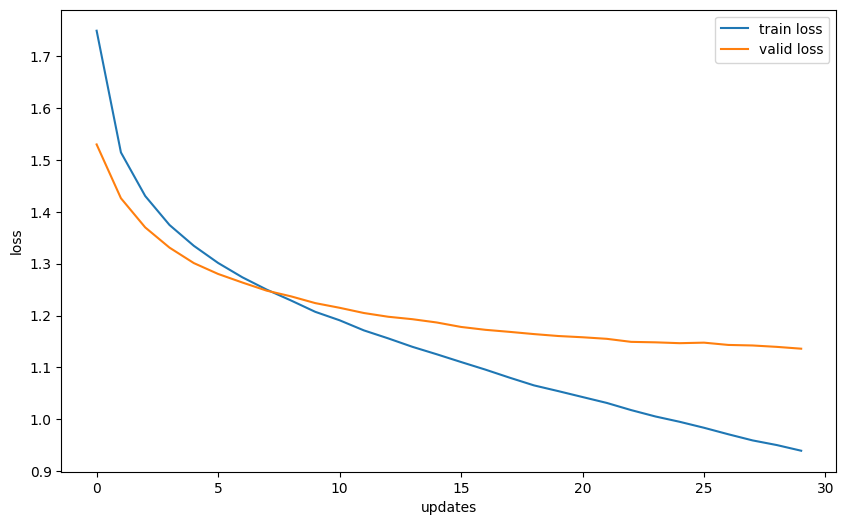

In [49]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

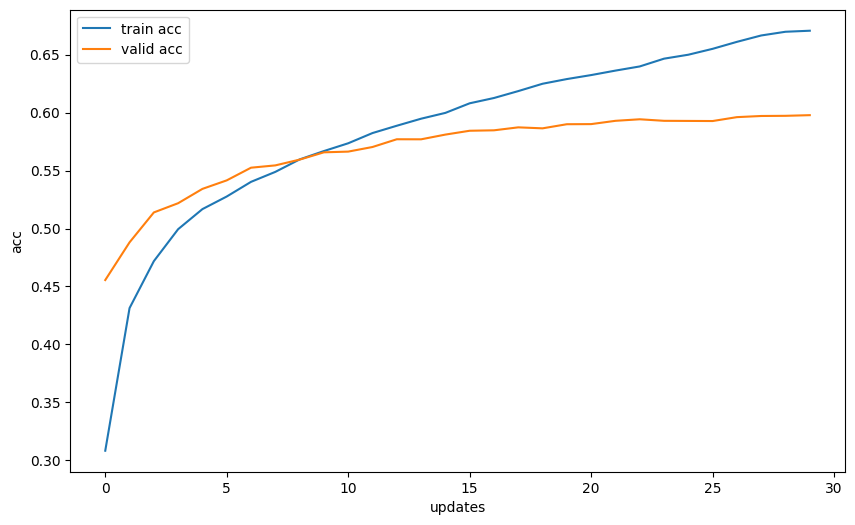

In [50]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')